# SOLUTION 1: Try to define quantifiers 

## Introduction: Libraries and example

In [202]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy
from skimage.filters import threshold_otsu,sobel,sobel_v,sobel_h 
from scipy import ndimage
import os
from os import listdir
from os.path import isfile, join
from PIL import Image
from scipy import io
import pandas as pd
dirname = os.getcwd()
dirname = os.path.join(dirname,'..','data','duke2D')
path_normal = os.path.join(dirname,'normal')
path_amd = os.path.join(dirname,'amd')

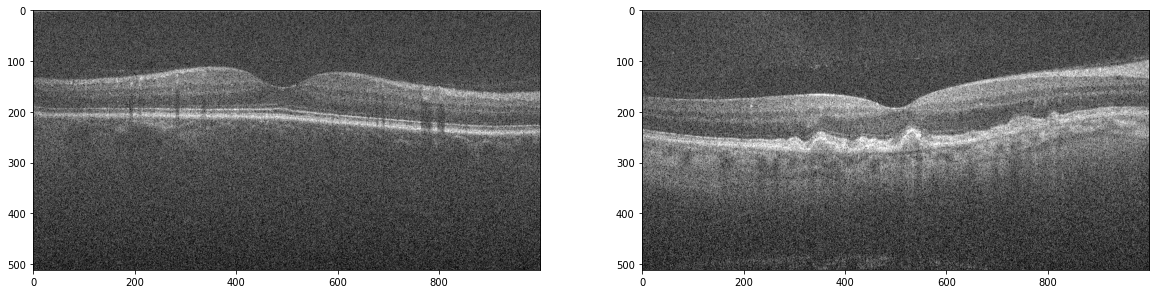

In [203]:
files_normal = [f for f in listdir(path_normal) if isfile(join(path_normal, f))]
files_amd = [f for f in listdir(path_amd) if isfile(join(path_amd, f))]
image_name_normal = files_normal[0]
image_name_amd = files_amd[1]
image_normal = mpimg.imread(os.path.join(path_normal,image_name_normal))
image_amd = mpimg.imread(os.path.join(path_amd,image_name_amd))
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(image_normal,cmap="gray")
plt.subplot(122)
plt.imshow(image_amd,cmap="gray")

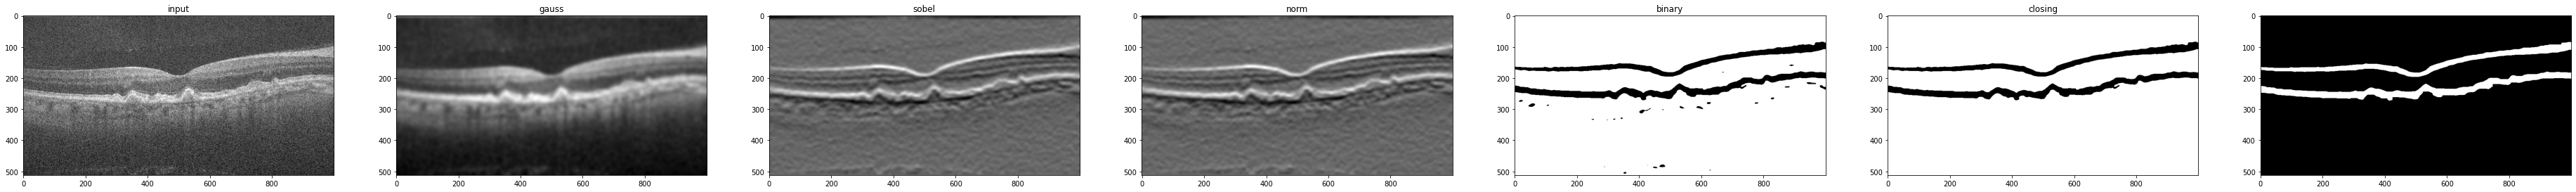

In [204]:
from scipy import ndimage
from scipy import signal
import skimage.filters as skifilt
import skimage.segmentation as skiseg
import skimage.morphology as skimorph
import cv2

input=image_amd # image_normal image_amd

# K=gaussian_kernel_xy(size=21, sigmax=8, sigmay=11)
# K=gaussian_kernel(size=20, sigma=11)
# i_gauss = ndimage.filters.convolve(input, K)
i_gauss = ndimage.gaussian_filter(input,sigma=5)

i_sobel_v=scipy.ndimage.sobel(i_gauss, axis=0, output=None, mode='reflect', cval=0.0)
i_sobel_h=scipy.ndimage.sobel(i_gauss, axis=1, output=None, mode='reflect', cval=0.0)

i_sobel=i_sobel_v #+i_sobel_h**2
i_normalized = (i_sobel-np.min(i_sobel))/(np.max(i_sobel)-np.min(i_sobel))
tho = skifilt.threshold_otsu(i_normalized)
tho = 0.5
i_bw = i_normalized<tho
i_rh = skimorph.remove_small_holes(i_bw,area_threshold=2000)

kernel = np.ones((20,20),np.uint8)
i_rh_8 = np.array(1-i_rh, dtype=np.uint8)
i_closing = cv2.morphologyEx(i_rh_8, op=cv2.MORPH_CLOSE,kernel=kernel)
# i_dil=skimorph.area_closing(i_rh,area_threshold=50000)

fig,ax = plt.subplots(1,7,figsize=(65,5))
ax[0].imshow(input,cmap='gray');		ax[0].set_title("input")
ax[1].imshow(i_gauss,cmap='gray');		ax[1].set_title("gauss")
ax[2].imshow(i_sobel,cmap='gray');		ax[2].set_title("sobel")
ax[3].imshow(i_normalized,cmap='gray'); ax[3].set_title("norm")
ax[4].imshow(i_bw,cmap='gray');			ax[4].set_title("binary")
ax[5].imshow(i_rh,cmap='gray');			ax[5].set_title("remove holes")
ax[6].imshow(i_closing,cmap='gray');	ax[5].set_title("closing")
plt.show()



In [205]:
def mask(input,sigma=9,area_threshold=2000):
	i_gauss = ndimage.gaussian_filter(input,sigma)

	i_sobel_v=scipy.ndimage.sobel(i_gauss, axis=0, output=None, mode='reflect', cval=0.0)
	i_sobel_h=scipy.ndimage.sobel(i_gauss, axis=1, output=None, mode='reflect', cval=0.0)

	i_sobel=i_sobel_v #+i_sobel_h**2
	i_normalized = (i_sobel-np.min(i_sobel))/(np.max(i_sobel)-np.min(i_sobel))
	tho = skifilt.threshold_otsu(i_normalized)
	i_bw = i_normalized<tho
	i_rh = skimorph.remove_small_holes(i_bw,area_threshold)

	kernel = np.ones((20,20),np.uint8)
	i_rh_8 = np.array(1-i_rh, dtype=np.uint8)
	i_closing = cv2.morphologyEx(i_rh_8, op=cv2.MORPH_CLOSE,kernel=kernel)
	return(i_closing)



In [206]:
N=10
list_im=np.random.randint(0,len(files_amd),N)

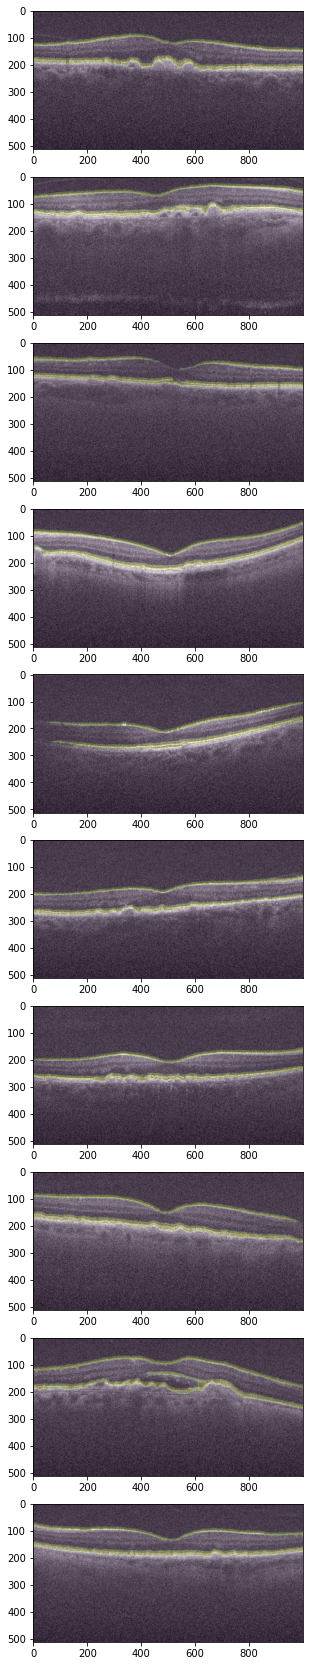

In [207]:
fig,ax=plt.subplots(N,1,figsize=(5,3*N))
for j,i in enumerate(list_im):
	image_name_amd = files_amd[i]
	image_amd = mpimg.imread(os.path.join(path_amd,image_name_amd))
	i_closing=mask(image_amd,sigma=5,area_threshold=2000)
	ax[j].imshow(image_amd,cmap='gray',alpha=1)
	ax[j].imshow(i_closing,alpha=0.2)

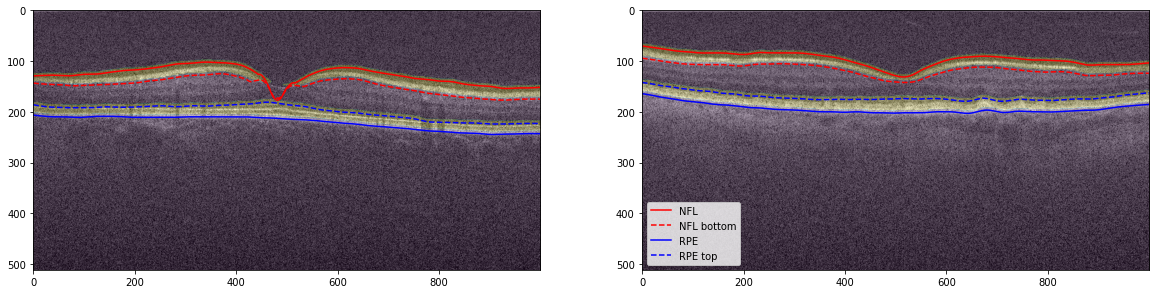

In [208]:
def first_layer(im):
    n,m = im.shape
    position=[]
    for i in range(m): #for each A scan
        ascan=im[:,i]
        max_pos = np.argmax(ascan)
        position.append(max_pos)
    return(position)

def first_layer_bottom(im,layer):
    n,m = im.shape
    position=[]
    for i in range(m):
        ascan=im[:,i]
        ascan=ascan[int(layer[i])+1:]
        max_pos = np.argmin(ascan)+int(layer[i])
        position.append(max_pos)
    return(position)

def last_layer(im):
    n,m = im.shape
    position=[]
    for i in range(m):
        ascan=im[:,i]
        ascan=ascan[::-1]
        max_pos = np.argmax(ascan)
        position.append(n-max_pos)
    return(position)

def last_layer_top(im,layer):
    n,m = im.shape
    position=[]
    for i in range(m):
        ascan=im[:,i]
        ascan=ascan[:int(layer[i])-1]
        ascan=ascan[::-1]
        max_pos = np.argmin(ascan)
        position.append(int(layer[i])-max_pos)
    return(position)

def jump_filter(layer,jump=10,offset=1):
    new_layer=layer
    for i in range(offset,len(layer)):
        if( np.abs(new_layer[i-offset]-new_layer[i])>jump ):
            if np.abs(new_layer[i]-new_layer[i-offset])<np.abs(new_layer[i]-layer[i-offset]):
                new_layer[i]=new_layer[i-offset]
            else:
                new_layer[i]=layer[i-offset]
    return(new_layer)

def golay_filter(layer):
    layer_smooth=signal.savgol_filter(layer,polyorder=2, window_length=51, deriv=0, delta=10.0, axis=- 1, mode='interp', cval=0.0)
    return(layer_smooth)


def layers(i_closing,jump=10,offset=1):
	f_l=first_layer(i_closing)
	# f_l=jump_filter(f_l,jump,offset)
	f_l=golay_filter(f_l)

	b_f_l=first_layer_bottom(i_closing,f_l)
	# b_f_l=jump_filter(b_f_l,jump,offset)
	b_f_l=golay_filter(b_f_l)

	l_l=last_layer(i_closing)
	# l_l=jump_filter(l_l,jump,offset)
	l_l=golay_filter(l_l)

	t_l_l=last_layer_top(i_closing,l_l)
	# t_l_l=jump_filter(t_l_l,jump,offset)
	t_l_l=golay_filter(t_l_l)
	return(f_l,l_l,b_f_l,t_l_l)
# np.where(layer==None)

plt.figure(figsize=(20,5))

i_closing=mask(image_normal)
f_l,l_l,b_f_l,t_l_l=layers(i_closing)
plt.subplot(121)
plt.imshow(image_normal,cmap='gray')
plt.imshow(i_closing,alpha=0.2)
plt.plot(f_l+5,'r',label="NFL")
plt.plot(b_f_l+5,'r--',label="NFL bottom")
plt.plot(l_l+5,'b',label="RPE")
plt.plot(t_l_l+5,'b--',label="RPE top")

i_closing=mask(image_amd)
f_l,l_l,b_f_l,t_l_l=layers(i_closing)
plt.subplot(122)
plt.imshow(image_amd,cmap='gray')
plt.imshow(i_closing,alpha=0.2)
plt.plot(f_l+5,'r',label="NFL")
plt.plot(b_f_l+5,'r--',label="NFL bottom")
plt.plot(l_l+5,'b',label="RPE")
plt.plot(t_l_l+5,'b--',label="RPE top")
plt.legend()

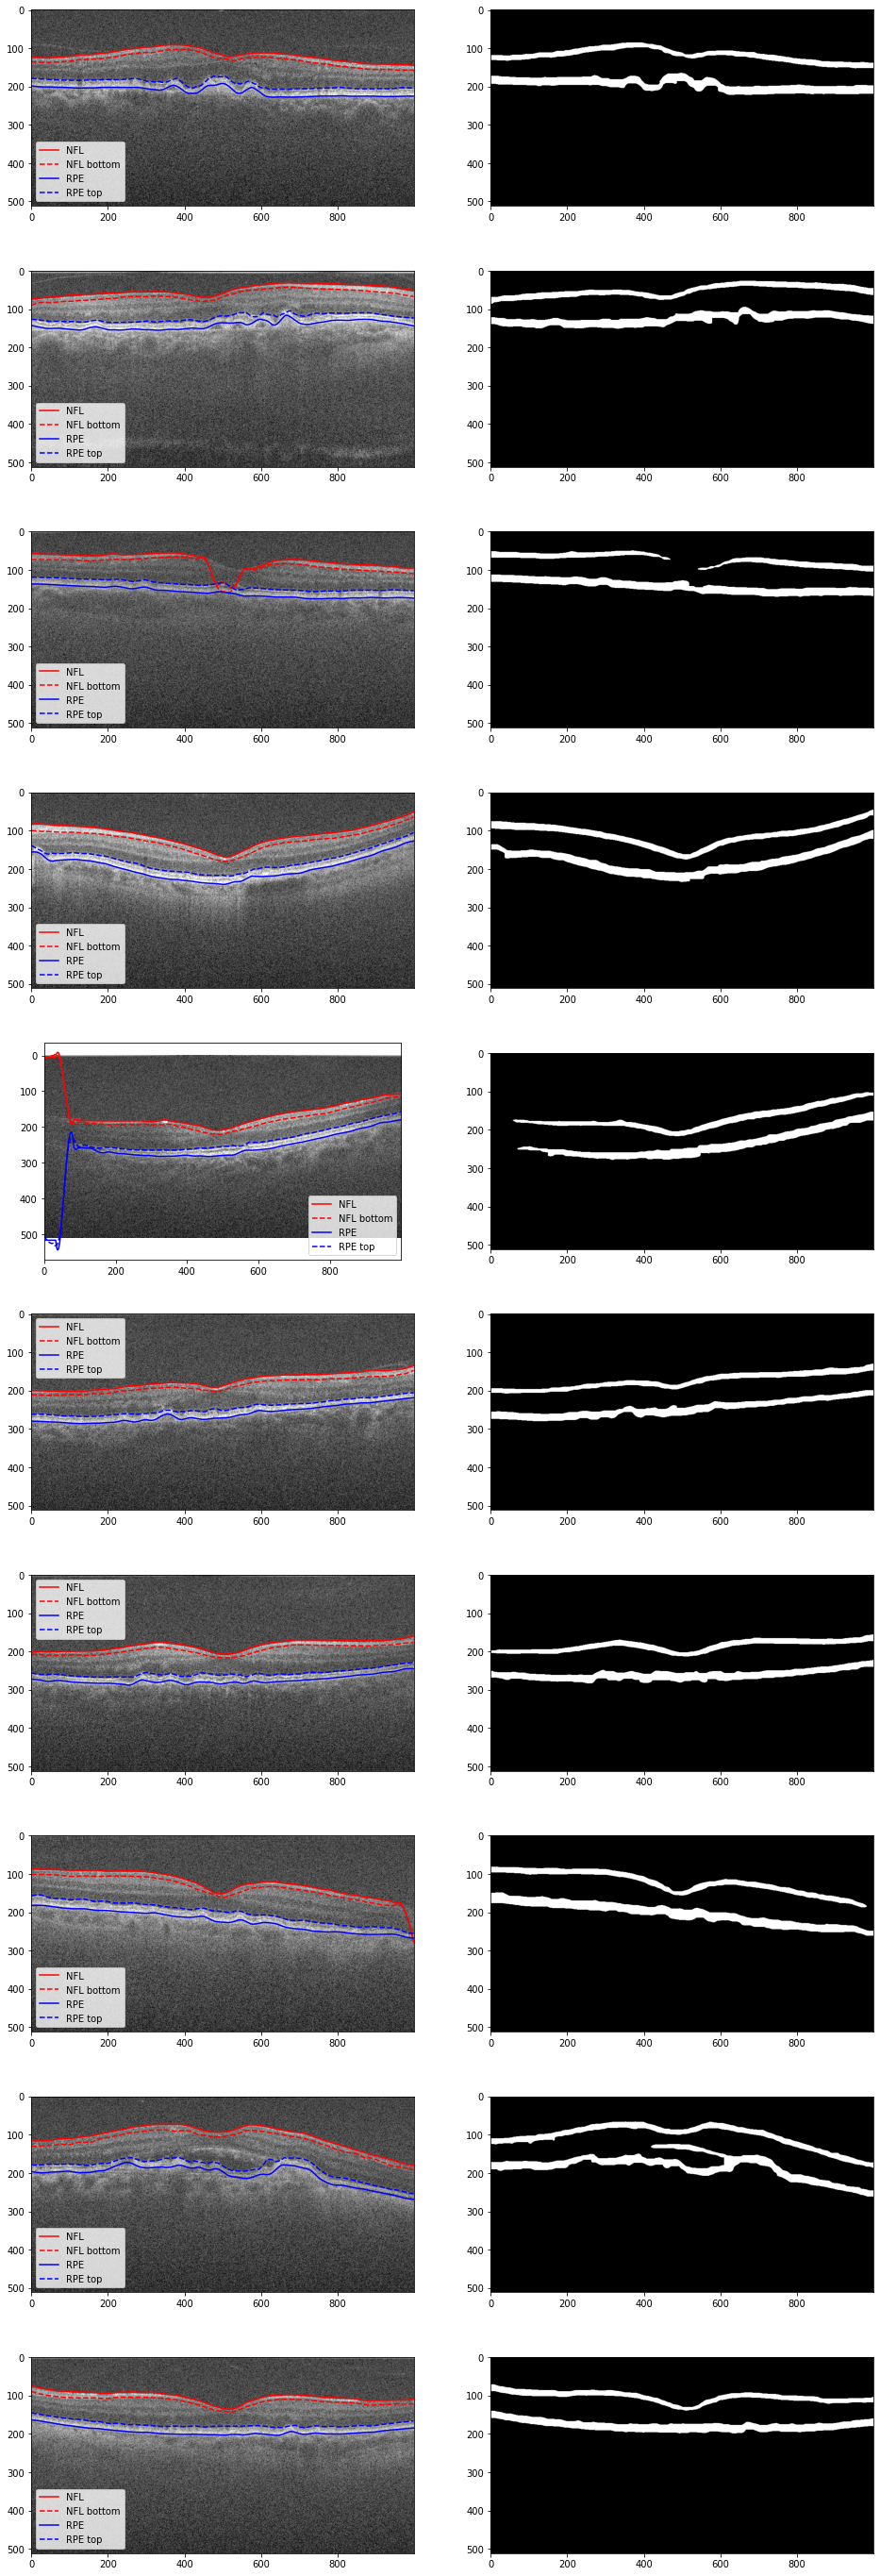

In [209]:
fig,ax=plt.subplots(N,2,figsize=(16,5*N))
for j,i in enumerate(list_im):
	image_name_amd = files_amd[i]
	image_amd = mpimg.imread(os.path.join(path_amd,image_name_amd))
	i_closing=mask(image_amd,sigma=5,area_threshold=2000)
	f_l,l_l,b_f_l,t_l_l=layers(i_closing,jump=20,offset=1)
	ax[j][0].imshow(image_amd,cmap='gray',alpha=1)
	ax[j][1].imshow(i_closing,cmap='gray')
	ax[j][0].plot(f_l+5,'r',label="NFL")
	ax[j][0].plot(b_f_l+5,'r--',label="NFL bottom")
	ax[j][0].plot(l_l+5,'b',label="RPE")
	ax[j][0].plot(t_l_l+5,'b--',label="RPE top")
	ax[j][0].legend()

## Image analyze process

Text(0.5, 1.0, 'AMD NSR')

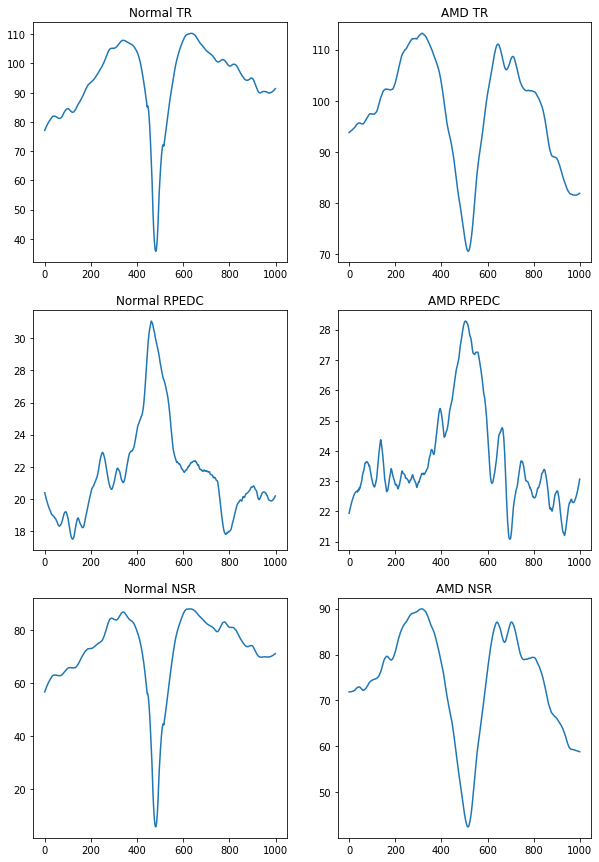

In [210]:
def TR_layers(layers):
    f_l,l_l,b_f_l,t_l_l=layers
    return(l_l-f_l)

def RPEDC_layers(layers):
    f_l,l_l,b_f_l,t_l_l=layers
    return(l_l-t_l_l)

def NSR_layers(layers):
    f_l,l_l,b_f_l,t_l_l=layers
    return(t_l_l-f_l)

def Convexity_layers(layers):
    f_l,l_l,b_f_l,t_l_l=layers
    layer_smooth=signal.savgol_filter(l_l,polyorder=2, window_length=51, deriv=2, delta=10.0, axis=- 1, mode='interp', cval=0.0)
    val=np.mean(10000*np.abs(layer_smooth))
    return(val)

plt.figure(figsize=(10,15))
i_closing=mask(image_normal)
layers_=layers(i_closing)
plt.subplot(321)
plt.plot(TR_layers(layers_))
plt.title("Normal TR")
plt.subplot(323)
plt.plot(RPEDC_layers(layers_))
plt.title("Normal RPEDC")
plt.subplot(325)
plt.plot(NSR_layers(layers_))
plt.title("Normal NSR")

i_closing=mask(image_amd)
layers_=layers(i_closing)
plt.subplot(322)
plt.plot(TR_layers(layers_))
plt.title("AMD TR")
plt.subplot(324)
plt.plot(RPEDC_layers(layers_))
plt.title("AMD RPEDC")
plt.subplot(326)
plt.plot(NSR_layers(layers_))
plt.title("AMD NSR")



## Quantifiers

In [226]:
try:
	df_QT = pd.read_pickle("../dataset/solution1_quantifiers.pkl")
	TR_normal=df_QT[ df_QT["Type"]=="control"]["TR"].to_numpy()
	RPEDC_normal=df_QT[ df_QT["Type"]=="control"]["RPEDC"].to_numpy()
	NSR_normal=df_QT[ df_QT["Type"]=="control"]["NSR"].to_numpy()
	TR_amd=df_QT[ df_QT["Type"]=="AMD"]["TR"].to_numpy()
	RPEDC_amd=df_QT[ df_QT["Type"]=="AMD"]["RPEDC"].to_numpy()
	NSR_amd=df_QT[ df_QT["Type"]=="AMD"]["NSR"].to_numpy()
except:
	TR_normal=[]
	RPEDC_normal=[]
	NSR_normal=[]

	df_QT=[]
	for f in files_normal:
		image_normal = mpimg.imread(os.path.join(path_normal,f))
		# i_closing=mask(image_normal)
		# layers_=layers(i_closing)
		i_closing=mask(image_normal,sigma=5,area_threshold=2000)
		layers_=layers(i_closing,jump=20,offset=1)
		TR_normal.append(TR_layers(layers_))
		RPEDC_normal.append(RPEDC_layers(layers_))
		NSR_normal.append(NSR_layers(layers_))
		parameters={
			'TR': TR_layers(layers_),
			'RPEDC': RPEDC_layers(layers_),
			'NSR': NSR_layers(layers_),
			'Convexity': Convexity_layers(layers_),
			'Type': "control",
			'Origin': f
		}
		df_QT.append(parameters)
	
	TR_amd=[]
	RPEDC_amd=[]
	NSR_amd=[]

	for f in files_amd:
		image_amd = mpimg.imread(os.path.join(path_amd,f))
		# i_closing=mask(image_amd)
		# layers_=layers(i_closing)
		i_closing=mask(image_amd,sigma=5,area_threshold=2000)
		layers_=layers(i_closing,jump=20,offset=1)
		TR_amd.append(TR_layers(layers_))
		RPEDC_amd.append(RPEDC_layers(layers_))
		NSR_amd.append(NSR_layers(layers_))
		parameters={
			'TR': TR_layers(layers_),
			'RPEDC': RPEDC_layers(layers_),
			'NSR': NSR_layers(layers_),
			'Convexity': Convexity_layers(layers_),
			'Type': "AMD",
			'Origin': f
		}
		df_QT.append(parameters)
	df_QT=pd.DataFrame(df_QT)
	df_QT.to_pickle("../dataset/solution1_quantifiers.pkl")
df_QT

TR  \
0    [74.06283616494494, 74.3246170921199, 74.57785...   
1    [88.68146503884566, 88.81543584051903, 88.9445...   
2    [80.58644241441132, 80.62195167762314, 80.6583...   
3    [69.19482626141897, 69.32384530009395, 69.4540...   
4    [73.18372748228465, 73.77634081789465, 74.3501...   
..                                                 ...   
379  [82.86613164859564, 82.80889268334336, 82.7546...   
380  [14.579783146930737, 14.816996499615811, 15.04...   
381  [114.20780329548376, 113.61544608554607, 113.0...   
382  [14.326901733116983, 14.261067190301304, 14.19...   
383  [73.16989669597885, 73.36489370784602, 73.5528...   

                                                 RPEDC  \
0    [19.009818150772645, 18.90800648851703, 18.808...   
1    [17.052420387603405, 17.088120891317246, 17.12...   
2    [15.411167079313572, 15.319836079569711, 15.23...   
3    [19.32587723042772, 19.339260650559197, 19.353...   
4    [6.3835908819260965, 7.250139161615323, 8.0922...   
..                                                 ...   
379  [19.895073849568902, 19.85083240843511, 19.808...   
380  [13.579783146930765, 13.816996499615811, 14.04...   
381  [19.042175360710473, 18.989874498420704, 18.93...   
382  [13.500213438060172, 13.404531716895633, 13.31...   
383  [21.228122598821813, 21.258666438999413, 21.28...   

                                                   NSR  Convexity     Type  \
0    [55.053018014172295, 55.41661060360286, 55.769...   0.173707  control   
1    [71.62904465124225, 71.72731494920178, 71.8215...   0.120323  control   
2    [65.17527533509775, 65.30211559805343, 65.4241...   0.152166  control   
3    [49.868949030991246, 49.98458464953475, 50.101...   0.143628  control   
4    [66.80013660035856, 66.52620165627933, 66.2579...   0.265922  control   
..                                                 ...        ...      ...   
379  [62.971057799026745, 62.95806027490824, 62.946...   0.578407      AMD   
380  [0.9999999999999716, 1.0, 0.9999999999999716, ...   0.843581      AMD   
381  [95.16562793477328, 94.62557158712536, 94.1028...   0.397594      AMD   
382  [0.8266882950568117, 0.8565354734056712, 0.884...   0.266114      AMD   
383  [51.94177409715704, 52.1062272688466, 52.26522...   0.723133      AMD   

                  Origin  
0    Control_2D_1001.png  
1    Control_2D_1002.png  
2    Control_2D_1003.png  
3    Control_2D_1004.png  
4    Control_2D_1005.png  
..                   ...  
379      AMD_2D_1265.png  
380      AMD_2D_1266.png  
381      AMD_2D_1267.png  
382      AMD_2D_1268.png  
383      AMD_2D_1269.png  

[384 rows x 6 columns]

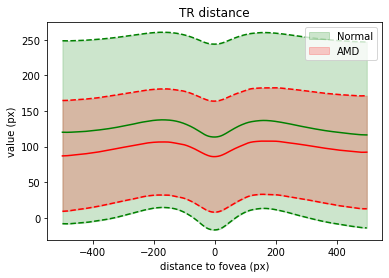

In [212]:
def var_to_stat(var):
	var=np.array(var)
	mean=np.mean(var,axis=0)
	std=np.std(var,axis=0)
	return(mean,std)

m,s=var_to_stat(TR_normal)
x=np.arange(-len(m)/2,len(m)/2)
plt.plot(x, m, "g")
plt.plot(x, m-s, "g--")
plt.plot(x, m+s, "g--")
plt.fill_between(x, m-s, m+s, color="green",alpha=0.2,label="Normal")

m,s=var_to_stat(TR_amd)
plt.plot(x, m, "r")
plt.plot(x, m-s, "r--")
plt.plot(x, m+s, "r--")
plt.fill_between(x, m-s, m+s, color="red",alpha=0.2,label="AMD")

plt.title("TR distance")
plt.xlabel('distance to fovea (px)')
plt.ylabel('value (px)')
plt.legend()

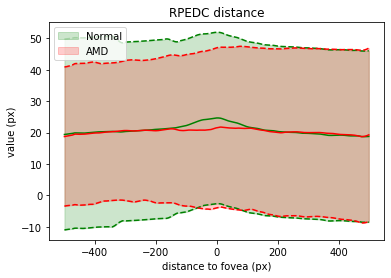

In [213]:
m,s=var_to_stat(RPEDC_normal)
x=np.arange(-len(m)/2,len(m)/2)
plt.plot(x, m, "g")
plt.plot(x, m-s, "g--")
plt.plot(x, m+s, "g--")
plt.fill_between(x, m-s, m+s, color="green",alpha=0.2,label="Normal")

m,s=var_to_stat(RPEDC_amd)
plt.plot(x, m, "r")
plt.plot(x, m-s, "r--")
plt.plot(x, m+s, "r--")
plt.fill_between(x, m-s, m+s, color="red",alpha=0.2,label="AMD")

plt.title("RPEDC distance")
plt.xlabel('distance to fovea (px)')
plt.ylabel('value (px)')
plt.legend()


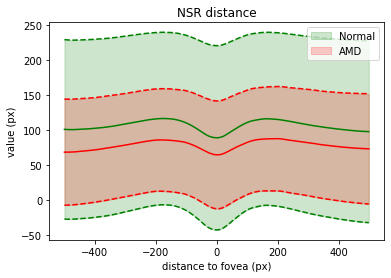

In [214]:
m,s=var_to_stat(NSR_normal)
x=np.arange(-len(m)/2,len(m)/2)

n_s=1
plt.plot(x, m, "g")
plt.plot(x, m-s, "g--")
plt.plot(x, m+s, "g--")
plt.fill_between(x, m-n_s*s, m+n_s*s, color="green",alpha=0.2,label="Normal")

m,s=var_to_stat(NSR_amd)
plt.plot(x, m, "r")
plt.plot(x, m-n_s*s, "r--")
plt.plot(x, m+n_s*s, "r--")
plt.fill_between(x, m-n_s*s, m+n_s*s, color="red",alpha=0.2,label="AMD")

plt.title("NSR distance")
plt.xlabel('distance to fovea (px)')
plt.ylabel('value (px)')
plt.legend()


### Outliers ?

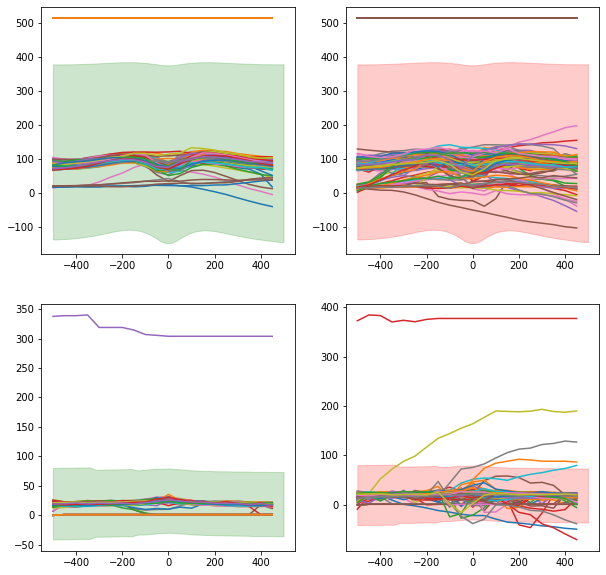

In [228]:
n_s=2

fig,ax=plt.subplots(2,2,figsize=(10,10))
N=len(TR_normal)
M=len(TR_normal[0])
step=50
x=np.arange(-M/2,M/2,step)
for i in range(N):    
	ax[0][0].plot(x,TR_normal[i][::step])
	ax[1][0].plot(x,RPEDC_normal[i][::step])
m,s=var_to_stat(TR_normal)
x=np.arange(-len(m)/2,len(m)/2)
ax[0][0].fill_between(x, m-n_s*s, m+n_s*s, color="green",alpha=0.2,label="Normal")
m,s=var_to_stat(RPEDC_normal)
ax[1][0].fill_between(x, m-n_s*s, m+n_s*s, color="green",alpha=0.2,label="Normal")


N=len(TR_amd)
M=len(TR_amd[0])
step=50
x=np.arange(-M/2,M/2,step)
for i in range(N):    
	ax[0][1].plot(x,TR_amd[i][::step])
	ax[1][1].plot(x,RPEDC_amd[i][::step])
m,s=var_to_stat(TR_normal)
x=np.arange(-len(m)/2,len(m)/2)
ax[0][1].fill_between(x, m-n_s*s, m+n_s*s, color="red",alpha=0.2,label="Normal")
m,s=var_to_stat(RPEDC_normal)
ax[1][1].fill_between(x, m-n_s*s, m+n_s*s, color="red",alpha=0.2,label="Normal")


### Filtering

In [229]:
N=len(TR_normal)
M=len(TR_normal[0])
n_s=2

m,s=var_to_stat(TR_normal)
index_drop_TR_normal=[]
for i in range(N):
    val= np.sum(TR_normal[i]>(m+n_s*s)) + np.sum(TR_normal[i]<(m-n_s*s))
    if val>0:
        index_drop_TR_normal.append(i)
m,s=var_to_stat(RPEDC_normal)
index_drop_RPEDC_normal=[]
for i in range(N):
    val= np.sum(RPEDC_normal[i]>(m+n_s*s)) + np.sum(RPEDC_normal[i]<(m-n_s*s))
    if val>0:
        index_drop_RPEDC_normal.append(i)

N=len(TR_amd)
M=len(TR_amd[0])

m,s=var_to_stat(TR_normal)
index_drop_TR_amd=[]
for i in range(N):
    val= np.sum(TR_amd[i]>(m+n_s*s)) + np.sum(TR_amd[i]<(m-n_s*s))
    if val>0:
        index_drop_TR_amd.append(i)
m,s=var_to_stat(RPEDC_normal)
index_drop_RPEDC_amd=[]
for i in range(N):
    val= np.sum(RPEDC_amd[i]>(m+n_s*s)) + np.sum(RPEDC_amd[i]<(m-n_s*s))
    if val>0:
        index_drop_RPEDC_amd.append(i)

TR_normal=np.delete(TR_normal,index_drop_TR_normal)
TR_amd=np.delete(TR_amd,index_drop_TR_amd)
RPEDC_normal=np.delete(RPEDC_normal,index_drop_RPEDC_normal)
RPEDC_amd=np.delete(RPEDC_amd,index_drop_RPEDC_amd)


In [230]:
index_drop_amd=np.concatenate((np.array(index_drop_TR_amd),np.array(index_drop_RPEDC_amd)))
index_drop_amd=np.unique(index_drop_amd)

index_drop_normal=np.concatenate((np.array(index_drop_TR_normal),np.array(index_drop_RPEDC_normal)))
index_drop_normal=np.unique(index_drop_normal)

In [231]:
index_df=df_QT[df_QT['Type']=='AMD'].index
df_QT=df_QT.drop(index_df[index_drop_amd])

index_df=df_QT[df_QT['Type']=='control'].index
df_QT=df_QT.drop(index_df[index_drop_normal])
df_QT

TR  \
0    [74.06283616494494, 74.3246170921199, 74.57785...   
1    [88.68146503884566, 88.81543584051903, 88.9445...   
2    [80.58644241441132, 80.62195167762314, 80.6583...   
3    [69.19482626141897, 69.32384530009395, 69.4540...   
4    [73.18372748228465, 73.77634081789465, 74.3501...   
..                                                 ...   
379  [82.86613164859564, 82.80889268334336, 82.7546...   
380  [14.579783146930737, 14.816996499615811, 15.04...   
381  [114.20780329548376, 113.61544608554607, 113.0...   
382  [14.326901733116983, 14.261067190301304, 14.19...   
383  [73.16989669597885, 73.36489370784602, 73.5528...   

                                                 RPEDC  \
0    [19.009818150772645, 18.90800648851703, 18.808...   
1    [17.052420387603405, 17.088120891317246, 17.12...   
2    [15.411167079313572, 15.319836079569711, 15.23...   
3    [19.32587723042772, 19.339260650559197, 19.353...   
4    [6.3835908819260965, 7.250139161615323, 8.0922...   
..                                                 ...   
379  [19.895073849568902, 19.85083240843511, 19.808...   
380  [13.579783146930765, 13.816996499615811, 14.04...   
381  [19.042175360710473, 18.989874498420704, 18.93...   
382  [13.500213438060172, 13.404531716895633, 13.31...   
383  [21.228122598821813, 21.258666438999413, 21.28...   

                                                   NSR  Convexity     Type  \
0    [55.053018014172295, 55.41661060360286, 55.769...   0.173707  control   
1    [71.62904465124225, 71.72731494920178, 71.8215...   0.120323  control   
2    [65.17527533509775, 65.30211559805343, 65.4241...   0.152166  control   
3    [49.868949030991246, 49.98458464953475, 50.101...   0.143628  control   
4    [66.80013660035856, 66.52620165627933, 66.2579...   0.265922  control   
..                                                 ...        ...      ...   
379  [62.971057799026745, 62.95806027490824, 62.946...   0.578407      AMD   
380  [0.9999999999999716, 1.0, 0.9999999999999716, ...   0.843581      AMD   
381  [95.16562793477328, 94.62557158712536, 94.1028...   0.397594      AMD   
382  [0.8266882950568117, 0.8565354734056712, 0.884...   0.266114      AMD   
383  [51.94177409715704, 52.1062272688466, 52.26522...   0.723133      AMD   

                  Origin  
0    Control_2D_1001.png  
1    Control_2D_1002.png  
2    Control_2D_1003.png  
3    Control_2D_1004.png  
4    Control_2D_1005.png  
..                   ...  
379      AMD_2D_1265.png  
380      AMD_2D_1266.png  
381      AMD_2D_1267.png  
382      AMD_2D_1268.png  
383      AMD_2D_1269.png  

[356 rows x 6 columns]

### Area

In [232]:
ascan_step=6.7/1000 #mm
df_QT["TR_A"]=df_QT["TR"].apply(np.sum)*ascan_step
df_QT["RPEDC_A"]=df_QT["RPEDC"].apply(np.sum)*ascan_step
df_QT["NSR_A"]=df_QT["NSR"].apply(np.sum)*ascan_step
df_QT.head()


TR  \
0  [74.06283616494494, 74.3246170921199, 74.57785...   
1  [88.68146503884566, 88.81543584051903, 88.9445...   
2  [80.58644241441132, 80.62195167762314, 80.6583...   
3  [69.19482626141897, 69.32384530009395, 69.4540...   
4  [73.18372748228465, 73.77634081789465, 74.3501...   

                                               RPEDC  \
0  [19.009818150772645, 18.90800648851703, 18.808...   
1  [17.052420387603405, 17.088120891317246, 17.12...   
2  [15.411167079313572, 15.319836079569711, 15.23...   
3  [19.32587723042772, 19.339260650559197, 19.353...   
4  [6.3835908819260965, 7.250139161615323, 8.0922...   

                                                 NSR  Convexity     Type  \
0  [55.053018014172295, 55.41661060360286, 55.769...   0.173707  control   
1  [71.62904465124225, 71.72731494920178, 71.8215...   0.120323  control   
2  [65.17527533509775, 65.30211559805343, 65.4241...   0.152166  control   
3  [49.868949030991246, 49.98458464953475, 50.101...   0.143628  control   
4  [66.80013660035856, 66.52620165627933, 66.2579...   0.265922  control   

                Origin        TR_A     RPEDC_A       NSR_A  
0  Control_2D_1001.png  600.095142  138.016425  462.078717  
1  Control_2D_1002.png  588.215062  126.764555  461.450507  
2  Control_2D_1003.png  566.524388  121.236775  445.287612  
3  Control_2D_1004.png  573.409475  143.577359  429.832116  
4  Control_2D_1005.png  646.103436  123.593309  522.510127

C:\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


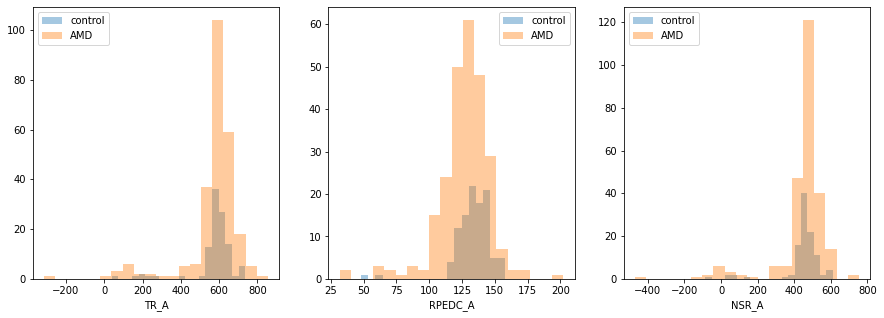

In [233]:
import seaborn as sns
fig,ax=plt.subplots(1,3,figsize=(15,5))
sns.distplot(df_QT[df_QT["Type"]=="control"]["TR_A"],  kde=False, label='control',bins=20,ax=ax[0])
sns.distplot(df_QT[df_QT["Type"]=="AMD"]["TR_A"],  kde=False,label='AMD',bins=20,ax=ax[0])
ax[0].legend()

sns.distplot(df_QT[df_QT["Type"]=="control"]["RPEDC_A"],  kde=False, label='control',bins=20,ax=ax[1])
sns.distplot(df_QT[df_QT["Type"]=="AMD"]["RPEDC_A"],  kde=False,label='AMD',bins=20,ax=ax[1])
ax[1].legend()

sns.distplot(df_QT[df_QT["Type"]=="control"]["NSR_A"],  kde=False, label='control',bins=20,ax=ax[2])
sns.distplot(df_QT[df_QT["Type"]=="AMD"]["NSR_A"],  kde=False,label='AMD',bins=20,ax=ax[2])
ax[2].legend()

### Abnormal score

In [234]:
mean_RPEDC = np.mean(df_QT[df_QT["Type"]=="control"]["RPEDC"].to_numpy(),axis=0)
mean_RPEDC = (mean_RPEDC[:500] + mean_RPEDC[500:])/2
std_RPEDC = np.std(df_QT[df_QT["Type"]=="control"]["RPEDC"].to_numpy(),axis=0)
std_RPEDC = (std_RPEDC[:500] + std_RPEDC[500:])/2

tho=200
n_s=1
upper_limit = mean_RPEDC + n_s * std_RPEDC
lower_limit = mean_RPEDC - n_s * std_RPEDC

thickness_excess_=df_QT["RPEDC"].apply(lambda x: (x[:500]+x[500:])/2-upper_limit)
thickness_excess_=thickness_excess_.apply(lambda x: x*(x>0)*std_RPEDC)
thickness_excess_=thickness_excess_.apply(np.sum)
thickness_excess_[thickness_excess_>tho]=tho
df_QT["thick_score"]=thickness_excess_

thinness_excess_=df_QT["RPEDC"].apply(lambda x: lower_limit-(x[:500]+x[500:])/2)
thinness_excess_=thinness_excess_.apply(lambda x: x*(x>0)*std_RPEDC)
thinness_excess_=thinness_excess_.apply(np.sum)
thinness_excess_[thinness_excess_>tho]=tho
df_QT["thin_score"]=thinness_excess_


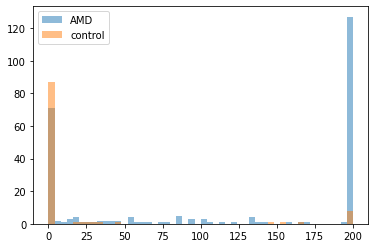

In [235]:
# df_QT[(df_QT["Type"]=="AMD")*(df_QT["thin_score"]>0)]["thin_score"]
plt.hist(df_QT[df_QT["Type"]=="AMD"]["thin_score"],alpha=0.5,label="AMD",bins=50)
plt.hist(df_QT[df_QT["Type"]=="control"]["thin_score"],alpha=0.5,label="control",bins=50)
plt.legend()

### Convexity ? 

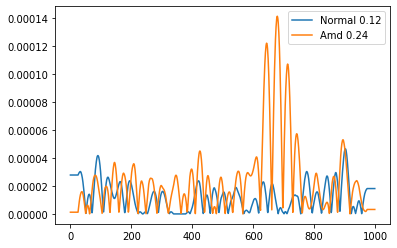

In [236]:
i_closing=mask(image_normal)
f_l,l_l,b_f_l,t_l_l=layers(i_closing)
layer_smooth_normal=signal.savgol_filter(l_l,polyorder=2, window_length=51, deriv=2, delta=10.0, axis=- 1, mode='interp', cval=0.0)

i_closing=mask(image_amd)
f_l,l_l,b_f_l,t_l_l=layers(i_closing)
layer_smooth_amd=signal.savgol_filter(l_l,polyorder=2, window_length=51, deriv=2, delta=10.0, axis=- 1, mode='interp', cval=0.0)

layer_smooth=signal.savgol_filter(l_l,polyorder=2, window_length=51, deriv=2, delta=10.0, axis=- 1, mode='interp', cval=0.0)

plt.plot(np.abs(layer_smooth_normal),label='Normal {:.2f}'.format(np.mean(10000*np.abs(layer_smooth_normal))))
plt.plot(np.abs(layer_smooth_amd),label='Amd {:.2f}'.format(np.mean(10000*np.abs(layer_smooth_amd))))
plt.legend()

C:\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Convexity'>

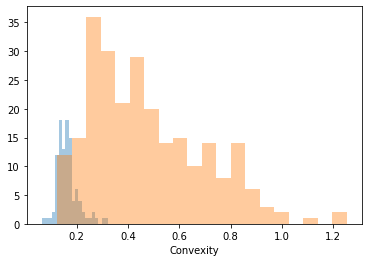

In [237]:
import seaborn as sns
sns.distplot(df_QT[df_QT["Type"]=="control"]["Convexity"],  kde=False, label='control',bins=20)
sns.distplot(df_QT[df_QT["Type"]=="AMD"]["Convexity"],  kde=False,label='AMD',bins=20)

## Learning
### Data

In [238]:
df_learning=df_QT.drop(['TR','RPEDC','NSR'],axis=1)
df_learning

Convexity     Type               Origin        TR_A     RPEDC_A  \
0     0.173707  control  Control_2D_1001.png  600.095142  138.016425   
1     0.120323  control  Control_2D_1002.png  588.215062  126.764555   
2     0.152166  control  Control_2D_1003.png  566.524388  121.236775   
3     0.143628  control  Control_2D_1004.png  573.409475  143.577359   
4     0.265922  control  Control_2D_1005.png  646.103436  123.593309   
..         ...      ...                  ...         ...         ...   
379   0.578407      AMD      AMD_2D_1265.png  766.225519  138.627634   
380   0.843581      AMD      AMD_2D_1266.png  204.907896  126.178001   
381   0.397594      AMD      AMD_2D_1267.png  772.314086  144.105474   
382   0.266114      AMD      AMD_2D_1268.png  144.776806  121.344242   
383   0.723133      AMD      AMD_2D_1269.png  565.016445  113.528869   

          NSR_A  thick_score  thin_score  
0    462.078717    31.997762    0.000000  
1    461.450507     0.000000    0.000000  
2    445.287612     0.000000   25.812105  
3    429.832116     2.711733    0.000000  
4    522.510127    42.656694  153.869232  
..          ...          ...         ...  
379  627.597885    96.141395    0.000000  
380   78.729895    12.927456  200.000000  
381  628.208612    33.806638    0.000000  
382   23.432564     0.000000  200.000000  
383  451.487576    64.566920  200.000000  

[356 rows x 8 columns]

In [249]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_learning, test_size=0.2, random_state=42, shuffle=True)

y_train=(train["Type"]=='AMD')
X_train=train.drop(["Type","Origin"],axis=1)
y_test=(test["Type"]=='AMD')
X_test=test.drop(["Type","Origin"],axis=1)

In [252]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
print("Train accuracy:",metrics.accuracy_score(y_train, clf.predict(X_train)))
y_pred=clf.predict(X_test)
print("Test accuracy:",metrics.accuracy_score(y_test, y_pred))

Train accuracy: 1.0
Test accuracy: 0.8888888888888888


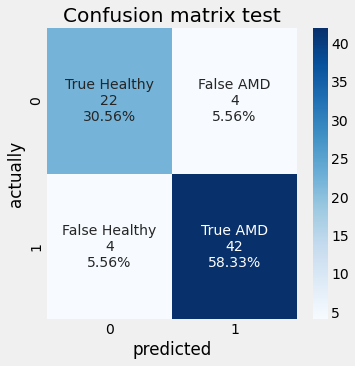

Accuracy test: 88.9%


Text(0.5, 0, 'Relative Importance')

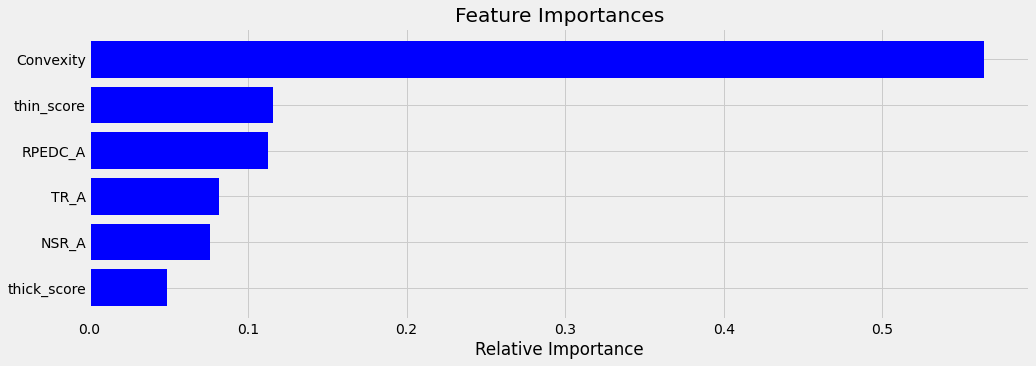

In [262]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cf_matrix=confusion_matrix(y_test, y_pred)

group_names = ['True Healthy','False AMD','False Healthy','True AMD']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(5,5))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion matrix test")
plt.xlabel("predicted")
plt.ylabel("actually")
plt.show()
print("Accuracy test: {:.1f}%".format(accuracy_score(y_test, y_pred)*100))


importances = clf.feature_importances_
indices = np.argsort(importances)
# style du graphique 
plt.figure(figsize=(15,5))
plt.style.use('fivethirtyeight')
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_test.columns[i] for i in indices])
plt.xlabel('Relative Importance')

In [264]:
sensitivity1 = cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[0,1])
print('Sensitivity (TPR=TP/P): ', sensitivity1 )

specificity1 = cf_matrix[1,1]/(cf_matrix[1,0]+cf_matrix[1,1])
print('Specificity (TNR=TN/N): ', specificity1)

Sensitivity (TPR=TP/P):  0.8461538461538461
Specificity (TNR=TN/N):  0.9130434782608695


In [253]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
print("Averaged accuracy: {:.1f}%".format(100*np.mean(scores)))
print(scores)

Averaged accuracy: 89.8%
[0.86206897 0.89655172 0.96551724 0.96551724 0.78571429 0.85714286
 0.85714286 0.96428571 0.96428571 0.85714286]


### Parameters
#### Max sample

>0.1 0.897 (0.060)
>0.2 0.904 (0.063)
>0.3 0.906 (0.060)
>0.4 0.898 (0.063)
>0.5 0.899 (0.064)
>0.6 0.894 (0.063)
>0.7 0.893 (0.055)
>0.8 0.894 (0.060)
>0.9 0.897 (0.059)
>1.0 0.896 (0.065)


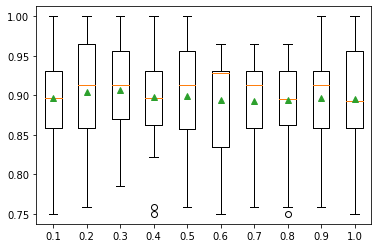

In [254]:
from sklearn.model_selection import RepeatedStratifiedKFold
# get a list of models to evaluate
def get_models():
	models = dict()
	# explore ratios from 10% to 100% in 10% increments
	for i in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		# set max_samples=None to use 100%
		if i == 1.0:
			i = None
		models[key] = RandomForestClassifier(max_samples=i)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

#### Max Features

>1 0.893 (0.066)
>2 0.892 (0.061)
>3 0.894 (0.057)
>4 0.890 (0.054)
>5 0.887 (0.050)
>6 0.885 (0.047)
>7 nan (nan)


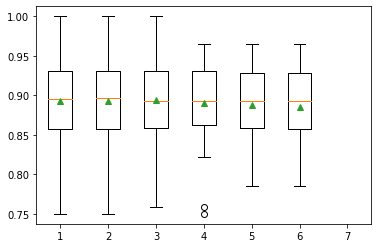

In [256]:

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore number of features from 1 to 7
	for i in range(1,8):
		models[str(i)] = RandomForestClassifier(max_features=i)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

#### Nb of tree

>10 0.887 (0.060)
>50 0.897 (0.050)
>100 0.900 (0.061)
>500 0.896 (0.062)
>1000 0.900 (0.063)


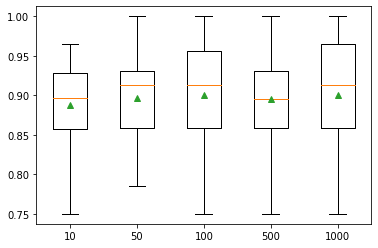

In [257]:
# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000]
	for n in n_trees:
		models[str(n)] = RandomForestClassifier(n_estimators=n)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

#### Tree depth

>1 0.833 (0.059)
>2 0.885 (0.069)
>3 0.899 (0.066)
>4 0.903 (0.066)
>5 0.898 (0.066)
>6 0.898 (0.065)
>7 0.902 (0.067)
>None 0.897 (0.065)


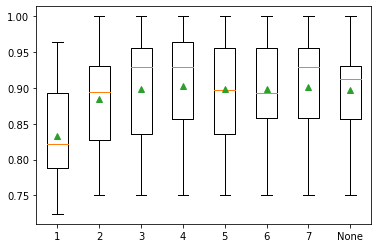

In [259]:
# get a list of models to evaluate
def get_models():
	models = dict()
	# consider tree depths from 1 to 7 and None=full
	depths = [i for i in range(1,8)] + [None]
	for n in depths:
		models[str(n)] = RandomForestClassifier(max_depth=n)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()